# Rivulet: U. S. EPA Air Quality System
_by Michelle H Wilkerson, Lucas Coletti_

## Purpose of this Notebook

This notebook was developed as part of NSF Grant 2445609 to support accessing and processing AirNow data for middle and high school classroom activities. It's written to be relatively accessible to beginners, but if you have not interacted with computational notebooks or python before you may find navigating this tool difficult. (Check out the Show Your Work project for a gentle introduction to computational notebooks for educators!)

Our project is focused on supporting data analysis and mechanistic reasoning in science education. In other words, we want students to learn how data provides information about _how scientific mechanisms work_, and how understanding scientific mechanisms can help them to _explain and interpret patterns in data_. This builds on a long history of research on complex systems and agent-based modeling, and more closely connects that work to current expansions of data analysis across subjects.

Here, we are focused on Air Quality as a phenomenon. While most students understand that poor Air Quality can impact health, they may not know that there are many different kinds of air pollution, each caused by different processes and chemicals. These are reflected by different patterns over the course of a day or year

This data tool allows users to connect to the Air Quality System API, search for air quality data streams in an area of interest, identify a date range of interest within that area, and then identifies which (if any) of the available data streams recorded observations for _both_ PM2.5 and O3 in that area and time range. These are two key pollutants that impact air quality and that tend to behave very differently over time. These kinds of datasets can serve as a launch to examining what AQ is and what are its underlying mechanistic and compositional complexities.

You are welcome to modify and adapt this script. You may find the AQS API documentation [here](https://aqs.epa.gov/aqsweb/documents/data_api.html) and the `pyaqsapi` documentation [here](https://usepa.github.io/pyaqsapi/) helpful.

# Part I: Connecting with AQS

Before you get started, you will need an AQS API Key. To get one, make a request using the url `https://aqs.epa.gov/data/api/signup?email=myemail@example.com` (replace myemail@example.com with your email). You will recieve a cute sounding API Key via email. Copy it and set EMAIL and API_KEY in the cell block below to your email and key from the service. (You can use the test email and key that are provided, however, the test account has a limited number of uses per day and may not work. Please register for an account if you would like to use the service.) If you need to reset your key, use this same url with the same email address.

In [45]:
%pip install pyaqsapi # python aqs helper

EMAIL = "test@aqs.api" #replace with your registered email
API_KEY = "test" # replace with your API key


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Ok, pyaqsapi is super friendly and gives us our data as dataframes. Let's take a look at the monitors available by site.

In [46]:
import pyaqsapi as aqs

try:
    aqs.aqs_credentials(username=EMAIL, key=API_KEY)
except Exception as e:
    print(f"Something didn't work: {e}")

Now, let's identify a location and time period that we want to explore. AQS can fetch data within a bounding box. Let's not get crazy - start with a relatively small bounding box (try one degree for an urban area) and get bigger if you need. (Tip: If you click on a location in Google Maps, you'll see the lat and long for that point in the URL.)

## Part II: Identifying a Focal Location and Date

This section allows you to specify a location and a date for which you would like to collect data. You'll need to know the approximate longitude and latitude of the region you are interested in. One easy way to do this is by asking Google "what is the longitude and latitude of [area]?" You will use the code in this section to use a minimum and maximum latitude and longitude to draw a bounding box around your location of interest. This will filter your future queries to focus only on air quality sensors found within that box. If you don't find any sensors, select a different location or increase the bounding box size.

In [123]:
# EDIT HERE: Define a bounding box around your
# target region. If it is densely populated, we suggest
# you start with a bounding box that is only one degree
# in area. 

min_lat = 37 # CHANGE TO YOUR MINIMUM LATITUDE
max_lat = 38 # CHANGE TO YOUR MAXIMUM LATITUDE

min_long = -122.5 # CHANGE TO YOUR MINIMUM LONGITUDE
max_long = -121.5

# this is unnecessary but sort of luxurious. let's map the box to
# make sure we're capturing what we want.

%pip install folium
import folium

bbox = [[min_lat, min_long], [max_lat, max_long]]

# Calculate the center of the box to position the map
map_center = [(bbox[0][0] + bbox[1][0]) / 2, (bbox[0][1] + bbox[1][1]) / 2]

# Create a Folium map object
m = folium.Map(location=map_center, zoom_start=8)

# Add a rectangle for the bounding box to the map
folium.Rectangle(
    bounds=bbox,
    color="#ff0000",        # Red border
    fill=True,
    fill_color="#ff7800",   # Orange fill
    fill_opacity=0.2
).add_to(m)

m


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [48]:
# EDIT HERE: identify a target date when something interesting
# was happening. Below, I define Jun 6 2023, a big wildfire smoke day in NY

from datetime import datetime, timedelta

target_date = "01-01-2020"
target_datetime = datetime.strptime(target_date, "%m-%d-%Y")

AQS has settings for different collections of parameters that reflect different "classes" of interest. For example, one parameter is SCHOOL AIR TOXICS which highligts 125 pollutants, or HAZARDOUS AIR POLLUTANTS with a total of 407 pollutants (!). Since we're only interested in O3 and PM, let's find a class that has those two and not much else so we're not taxing the system with our queries. AQI POLLUTANTS looks like a good one, it tracks the "big five" pollutants that are most commonly discussed along with a few other well known pollutants: 

In [96]:
try:
    parameter_list = aqs.aqs_parameters_by_class("AQI POLLUTANTS")
except Exception as e:
    print(f"Something didn't work: {e}")

parameter_list

,code,value_represented
0,42101,Carbon monoxide
1,42401,Sulfur dioxide
2,42602,Nitrogen dioxide (NO2)
3,44201,Ozone
4,81102,PM10 Total 0-10um STP
5,88101,PM2.5 - Local Conditions
6,88502,Acceptable PM2.5 AQI & Speciation Mass


From this list, you can select the specific AQI pollutant parameters that you want to fetch from any of the sequences below. We suggest Ozone (O3) and PM2.5, or Carbon monoxide (CO) and PM2.5.

## Part III: Fetching Selected Pollutants

In [97]:
# CUSTOMIZE THIS: Identify the parameters that you want to include in your dataset.
# By default, the list below includes Ozone and PM2.5, which tend to have very
# different dynamics. 

PARAMETERS = ('44201', '88101')

In [98]:
# RUN THIS: This code figures out what monitoring stations have the information you need.

bdate = target_datetime
edate = target_datetime + timedelta(days=1)

monitors = aqs.bybox.monitors(
    parameter= ','.join(PARAMETERS), # all six pollutants are listed
    bdate=bdate, 
    edate=edate,
    minlat=min_lat,
    maxlat=max_lat,
    minlon=min_long,
    maxlon=max_long,
)

# Filter the monitors so we are showing only the ones that have all requested parameters
relevant_monitors = monitors.groupby(
    ['state_code','county_code','site_number']).filter( # make groups of each monitor
    lambda group: set(group['parameter_code']) == set(PARAMETERS) # include only groups with both monitors
)


relevant_monitors[['state_code','county_code','site_number','address','city_name','county_name','state_name']].drop_duplicates()

<<<<< DEBUGGER CHECK: THIS LINE WAS REACHED >>>>>


,state_code,county_code,site_number,address,city_name,county_name,state_name
1,06,013,0002,2956-A TREAT BOULEVARD,Concord,Contra Costa,California
3,06,085,0005,158B JACKSON ST,San Jose,Santa Clara,California
5,06,013,1004,"1865 D RUMRILL BLVD, San Pablo",San Pablo,Contra Costa,California
6,06,001,0009,9925 International Blvd,Oakland,Alameda,California
8,06,075,0005,10 ARKANSAS ST.,San Francisco,San Francisco,California
9,06,001,0013,1 Bolivar Dr,Not in a City,Alameda,California
10,06,001,0007,793 Rincon Ave.,Livermore,Alameda,California
12,06,001,0011,1100 21st Street,Oakland,Alameda,California
22,06,081,1001,897 BARRON AVE.,Redwood City,San Mateo,California


Hopefully, at least one monitor in your designated area appeared that has all pollutants. If not, you may want to remove less commonly measured pollutants from the lambda filter above and see how close you can get.

In the code below we specify how many weeks of data we'd like to fetch around our target date. 

Now, let's identify the monitoring station we want from the table above, and enter the corresponding stateFIPS, countycode, and sitenum to get the data.

In [ ]:
# CUSTOMIZE THIS: Define the period of time for which you would like to fetch 
# data. By default, the code below specifies a beginning date of one week
# before the target date, and and end date of one week after.

beginningdate = target_datetime - timedelta(weeks=1)
enddate = target_datetime + timedelta(weeks=1)


In [89]:
# CUSTOMIZE THIS: Enter the stateFIPS, county_code, and sitenum of your preferred 
# monitoring station from the list above. By default, we have set this to a
# monitoring station in Concord, CA that we know reports all AQI pollutants.

aqdata = aqs.bysite.sampledata(parameter=','.join(PARAMETERS),
                      bdate=beginningdate,
                      edate=enddate,
                      stateFIPS="06", # enter the state_code here
                      countycode="013", # enter the county_code here
                      sitenum="0002") # enter the site_number here

aqdata.head()

<<<<< DEBUGGER CHECK: THIS LINE WAS REACHED >>>>>


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,date_local,...,detection_limit,uncertainty,qualifier,method_type,method,method_code,state,county,date_of_last_change,cbsa_code
0,06,013,0002,42101,1,37.936013,-122.026154,WGS84,Carbon monoxide,2020-01-01,...,0.5,None,None,FRM,INSTRUMENTAL - NONDISPERSIVE INFRARED,054,California,Contra Costa,2020-07-16,41860
1,06,013,0002,42101,1,37.936013,-122.026154,WGS84,Carbon monoxide,2020-01-01,...,0.5,None,None,FRM,INSTRUMENTAL - NONDISPERSIVE INFRARED,054,California,Contra Costa,2020-07-16,41860
2,06,013,0002,42101,1,37.936013,-122.026154,WGS84,Carbon monoxide,2020-01-01,...,0.5,None,BD - Auto Calibration.,FRM,INSTRUMENTAL - NONDISPERSIVE INFRARED,054,California,Contra Costa,2020-07-16,41860
3,06,013,0002,42101,1,37.936013,-122.026154,WGS84,Carbon monoxide,2020-01-01,...,0.5,None,None,FRM,INSTRUMENTAL - NONDISPERSIVE INFRARED,054,California,Contra Costa,2020-07-16,41860
4,06,013,0002,42101,1,37.936013,-122.026154,WGS84,Carbon monoxide,2020-01-01,...,0.5,None,None,FRM,INSTRUMENTAL - NONDISPERSIVE INFRARED,054,California,Contra Costa,2020-07-16,41860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,06,013,0002,88101,3,37.936013,-122.026154,WGS84,PM2.5 - Local Conditions,2020-01-08,...,5.0,None,None,FEM,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,170,California,Contra Costa,2020-07-16,41860
960,06,013,0002,88101,3,37.936013,-122.026154,WGS84,PM2.5 - Local Conditions,2020-01-08,...,5.0,None,None,FEM,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,170,California,Contra Costa,2020-07-16,41860
961,06,013,0002,88101,3,37.936013,-122.026154,WGS84,PM2.5 - Local Conditions,2020-01-08,...,5.0,None,None,FEM,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,170,California,Contra Costa,2020-07-16,41860
962,06,013,0002,88101,3,37.936013,-122.026154,WGS84,PM2.5 - Local Conditions,2020-01-08,...,5.0,None,None,FEM,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,170,California,Contra Costa,2020-07-16,41860


In [ ]:
# RUN THIS: Plot a grid of reported levels for each pollutant, plus composite AQI

import seaborn as sns

# All that dataframe action messes us the indices. 
# We need to reset the index to visualize everything together.
aqdata = aqdata.reset_index()

g = sns.FacetGrid(aqdata, 
                  row="parameter_code", 
                  aspect=4, # this makes the graphs 4x wider than they are tall
                  sharey=False) # this treats the scale for each pollutant separately

g.map(sns.lineplot, "datetime_local", "sample_measurement")

If this set of data looks interesting enough to keep working with, use the code below to export to csv.

In [ ]:
aqdata.to_csv("pollutantlevels.csv")

# Part IV: Reconstructing AQI from Pollutant Levels

AQI is what's know as a composite index. It looks at the concentrations and risk levels of a core set of six major pollutants (the ones we reviewed as AQI POLLUTANTS above), and reports the highest risk level from those pollutants at a given time. 

The AQI is one number, and every 50 points represents a new level of hazard. The graphic below shows the general breakdown of AQI warning levels. 

<img src="https://cap-mzansi.com/wp-content/uploads/2023/06/shutterstock_1657303105-1536x602.webp" alt="alt text" width="500">

In the block below, we define what the EPA calles AQI "breakpoints" - these define how different pollutant measures are translated into risk levels that can be compared.

The code below should not be edited unless you know what you're doing, so we've left it collapsed. Think of it as extra background work to get you the data you need.

The functions we defined above report the AQI, given each constituent pollutant's concentration. Now what we want to do is find the monitoring stations that report all the necessary pollutants. Below, we include all six of the pollutants in the list called PARAMETERS. If you cannot find any monitoring stations that are tracking all the parameters, try reducing the full list to subsets of pollutants that are most frequently monitored, or that are most important for the region you are exploring (if you are not sure, we suggest trying PM10, PM2.5, and Ozone). 

In [ ]:
# CUSTOMIZE THIS: Identify the parameters that you want to include in your dataset.
# By default, the list below includes Ozone and PM2.5, which tend to have very
# different dynamics. 

# TODO modularize so that the user can just go to the last section and 
# perhaps reset the parameters? Chat with a few users.

PARAMETERS = ('44201', '88101', '42101', '42401', '42602', '81102')

In [ ]:
# RUN THIS: This code figures out what monitoring stations have the information you need.

bdate = target_datetime
edate = target_datetime + timedelta(days=1)

monitors = aqs.bybox.monitors(
    parameter= ','.join(PARAMETERS), # all six pollutants are listed
    bdate=bdate, 
    edate=edate,
    minlat=min_lat,
    maxlat=max_lat,
    minlon=min_long,
    maxlon=max_long,
)

# Filter the monitors so we are showing only the ones that have all requested parameters
relevant_monitors = monitors.groupby(
    ['state_code','county_code','site_number']).filter( # make groups of each monitor
    lambda group: set(group['parameter_code']) == set(PARAMETERS) # include only groups with both monitors
)


relevant_monitors[['state_code','county_code','site_number','address','city_name','county_name','state_name']].drop_duplicates()

<<<<< DEBUGGER CHECK: THIS LINE WAS REACHED >>>>>


,state_code,county_code,site_number,address,city_name,county_name,state_name
1,06,013,0002,2956-A TREAT BOULEVARD,Concord,Contra Costa,California
7,06,013,1004,"1865 D RUMRILL BLVD, San Pablo",San Pablo,Contra Costa,California
8,06,085,0005,158B JACKSON ST,San Jose,Santa Clara,California


In [ ]:
# CUSTOMIZE THIS: Define the period of time for which you would like to fetch 
# data. By default, the code below specifies a beginning date three days before
# the target date, and three days after (about a week of data).

beginningdate = target_datetime - timedelta(weeks=1)
enddate = target_datetime + timedelta(weeks=1)

In [ ]:
# CUSTOMIZE THIS: Enter the stateFIPS, county_code, and sitenum of your preferred 
# monitoring station from the list above. By default, we have set this to a
# monitoring station in Concord, CA that we know reports all AQI pollutants.

aqdata = aqs.bysite.sampledata(parameter=','.join(PARAMETERS),
                      bdate=beginningdate,
                      edate=enddate,
                      stateFIPS="06", # enter the state_code here
                      countycode="013", # enter the county_code here
                      sitenum="0002") # enter the site_number here

aqdata.head()

In [90]:
# RUN THIS: Define the EPA Air Quality Index (AQI) Breakpoints
# Format: (AQI_Low, AQI_High, Conc_Low, Conc_High)
AQI_BREAKPOINTS = {
    # PM2.5 (24-hr, in µg/m³)
    '88101': [
        (0, 50, 0.0, 12.0),
        (51, 100, 12.1, 35.4),
        (101, 150, 35.5, 55.4),
        (151, 200, 55.5, 150.4),
        (201, 300, 150.5, 250.4),
        (301, 400, 250.5, 350.4),
        (401, 500, 350.5, 500.4),
    ],
    # PM10 (24-hr, in µg/m³)
    '81102': [
        (0, 50, 0, 54),
        (51, 100, 55, 154),
        (101, 150, 155, 254),
        (151, 200, 255, 354),
        (201, 300, 355, 424),
        (301, 400, 425, 504),
        (401, 500, 505, 604),
    ],
    # O3 (8-hr, in ppm)
    '44201': [
        (0, 50, 0.000, 0.054),
        (51, 100, 0.055, 0.070),
        (101, 150, 0.071, 0.085),
        (151, 200, 0.086, 0.105),
        (201, 300, 0.106, 0.200),
        # Note: AQI > 200 for 8-hr O3 is calculated using 1-hr O3.
        # This implementation assumes you will provide the 8-hr value
        # and will cap at the 201-300 range.
    ],
    # O3 (1-hr, in ppm) - Used when 8-hr values are high TODO
    'O3_1hr': [
        (101, 150, 0.125, 0.164),
        (151, 200, 0.165, 0.204),
        (201, 300, 0.205, 0.404),
        (301, 400, 0.405, 0.504),
        (401, 500, 0.505, 0.604),
    ],
    # CO (8-hr, in ppm)
    '42101': [
        (0, 50, 0.0, 4.4),
        (51, 100, 4.5, 9.4),
        (101, 150, 9.5, 12.4),
        (151, 200, 12.5, 15.4),
        (201, 300, 15.5, 30.4),
        (301, 400, 30.5, 40.4),
        (401, 500, 40.5, 50.4),
    ],
    # SO2 (1-hr, in ppb)
    '42401': [
        (0, 50, 0, 35),
        (51, 100, 36, 75),
        (101, 150, 76, 185),
        (151, 200, 186, 304),
        (201, 300, 305, 604),
        (301, 400, 605, 804),
        (401, 500, 805, 1004),
    ],
    # NO2 (1-hr, in ppb)
    '42602': [
        (0, 50, 0, 53),
        (51, 100, 54, 100),
        (101, 150, 101, 360),
        (151, 200, 361, 649),
        (201, 300, 650, 1249),
        (301, 400, 1250, 1649),
        (401, 500, 1650, 2049),
    ],
}

In [91]:
# RUN THIS: Define functions to compute AQI composite measure.

import math

# different pollutant measurements are rounded to different places,
# this function will do the specified rounding. (TODO: Check if we actually need
# this depending on how data are reported by the AQS system)
def truncate(n, decimals=0):
    if not isinstance(n, (int, float)):
        return None
    if not math.isfinite(n):
        return None
    
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

# Specification for truncation decimals
POLLUTANT_SPECS = {
    '88101': {'decimals': 1},
    '81102': {'decimals': 0},
    '44201': {'decimals': 3},
    'O3_1hr': {'decimals': 3},
    '42101': {'decimals': 1},
    '42401': {'decimals': 0},
    '42602': {'decimals': 0},
}

def calculate_individual_aqi(pollutant_code, concentration):
    if pollutant_code not in AQI_BREAKPOINTS or \
       pollutant_code not in POLLUTANT_SPECS:
        print(f"Warning: Unknown pollutant code '{pollutant_code}'.")
        return None
        
    if concentration is None or concentration < 0 or \
       not math.isfinite(concentration):
        return None

    # 1. Truncate the concentration based on EPA spec
    decimals = POLLUTANT_SPECS[pollutant_code]['decimals']
    C_p = truncate(concentration, decimals)
    
    if C_p is None:
        return None

    # 2. Find the correct breakpoint category
    table = AQI_BREAKPOINTS[pollutant_code]
    
    for (I_lo, I_hi, C_lo, C_hi) in table:
        if C_lo <= C_p <= C_hi:
            # 3. Apply the linear interpolation formula
            # I_p = ((I_hi - I_lo) / (C_hi - C_lo)) * (C_p - C_lo) + I_lo
            
            # Avoid division by zero if C_hi == C_lo
            if (C_hi - C_lo) == 0:
                aqi = I_lo
            else:
                aqi = ((I_hi - I_lo) / (C_hi - C_lo)) * (C_p - C_lo) + I_lo
                
            return round(aqi)
            
    # If concentration is beyond the highest breakpoint,
    # use the last category for calculation
    (I_lo, I_hi, C_lo, C_hi) = table[-1]
    if C_p > C_hi:
        if (C_hi - C_lo) == 0:
            aqi = I_lo
        else:
            aqi = ((I_hi - I_lo) / (C_hi - C_lo)) * (C_p - C_lo) + I_lo
        return round(aqi)

    return None # Should not be reached

def calculate_composite_aqi(concentration_data):
    individual_aqis = []
    
    for pollutant_code, concentration in concentration_data.items():
        aqi = calculate_individual_aqi(pollutant_code, concentration)
        
        if aqi is not None:
            individual_aqis.append(aqi)
            
    # The composite AQI is the highest of the available individual AQIs
    if not individual_aqis:
        return None
        
    return max(individual_aqis)

In [92]:
# RUN THIS: Compute the individual AQI for each pollutant at each time point.

aqdata['individual_aqi'] = aqdata.apply(
    lambda row: calculate_individual_aqi(row['parameter_code'], row['sample_measurement']),
    axis=1
)

In [93]:
# RUN THIS: Add the composite AQI for each time point to the table

import pandas as pd

combined_series = aqdata['date_local'] + ' ' + aqdata['time_local']
aqdata['datetime_local'] = pd.to_datetime(combined_series, format="%Y-%m-%d %H:%M")

# Pivot so each row is a datetime and columns are pollutant codes with their measurements
measurements = aqdata.pivot_table(
    index='datetime_local',
    columns='parameter_code',
    values='sample_measurement',
    aggfunc='mean'  # if multiple readings per datetime/pollutant, take the mean
)

# Helper to build pollutant -> concentration dict and compute composite AQI
def _row_to_composite(row):
    conc = {str(code): row[code] for code in row.index if pd.notnull(row[code])}
    return calculate_composite_aqi(conc)

# Compute composite AQI for each datetime
measurements['composite_aqi'] = measurements.apply(_row_to_composite, axis=1)

# Make a tidy timeseries dataframe
aqi_timeseries = measurements[['composite_aqi']].reset_index().sort_values('datetime_local')

# Build new rows from the composite AQI timeseries and append to aqdata.
# Reuse existing variables: aqi_timeseries, aqdata, pandas already imported.

new_rows = pd.DataFrame({
    'datetime_local': aqi_timeseries['datetime_local'],
    'sample_measurement': aqi_timeseries['composite_aqi'],
    'parameter_code': 'COMPOSITE_AQI',     # tag so these rows are identifiable
    'parameter': 'Composite AQI',
    'individual_aqi': aqi_timeseries['composite_aqi']
})

# Concatenate and keep a consistent datetime dtype; sort by datetime if desired.
aqdata = pd.concat([aqdata, new_rows], ignore_index=True, sort=False)
aqdata['datetime_local'] = pd.to_datetime(aqdata['datetime_local'])
aqdata = aqdata.sort_values('datetime_local').reset_index(drop=True)

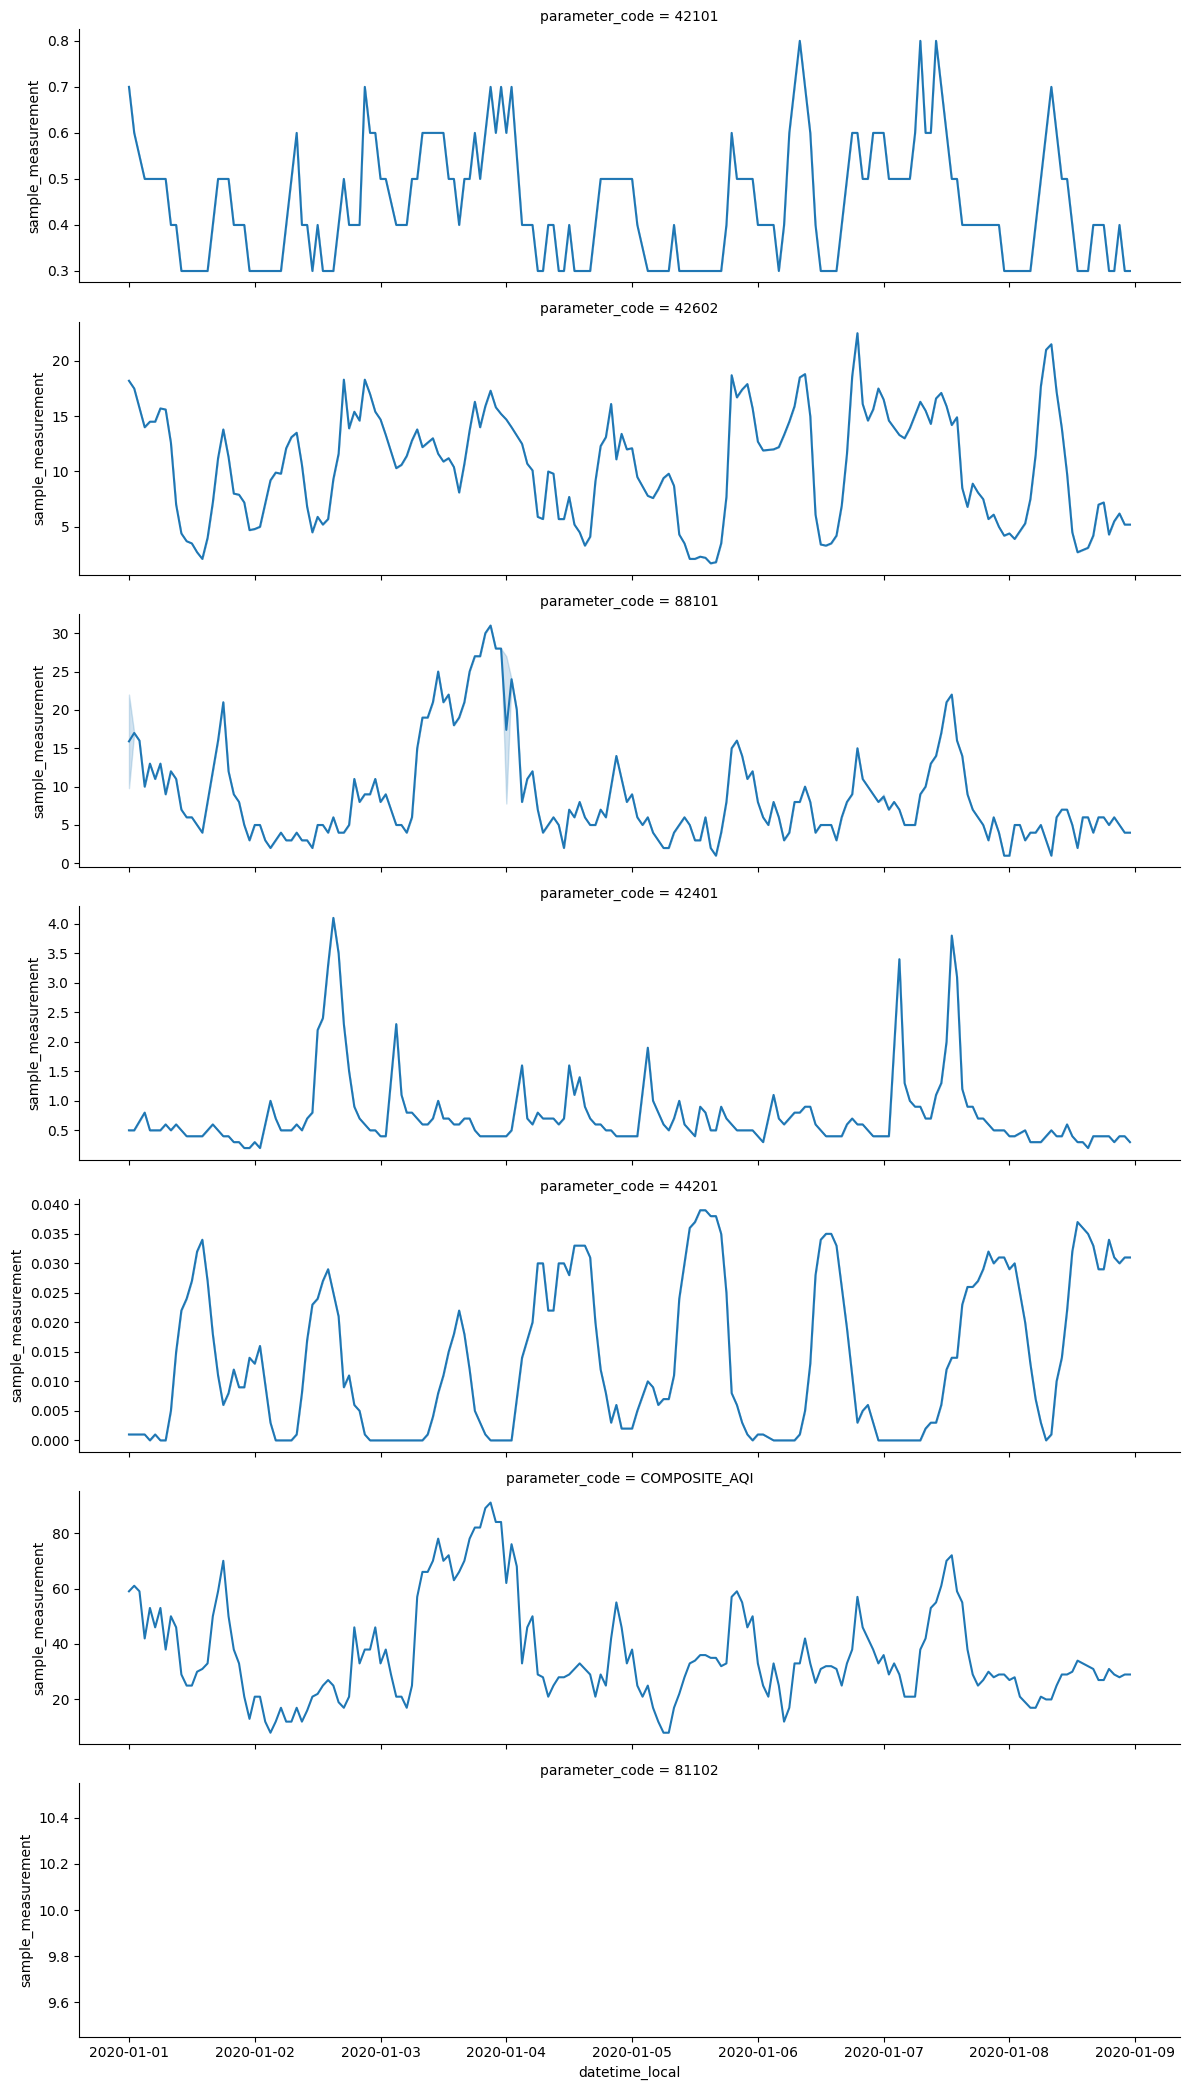

In [94]:
# RUN THIS: Plot a grid of reported levels for each pollutant, plus composite AQI

import seaborn as sns

# All that dataframe action messes us the indices. 
# We need to reset the index to visualize everything together.
aqdata = aqdata.reset_index()

g = sns.FacetGrid(aqdata, 
                  row="parameter_code", 
                  aspect=4, # this makes the graphs 4x wider than they are tall
                  sharey=False) # this treats the scale for each pollutant separately

g.map(sns.lineplot, "datetime_local", "sample_measurement")

If you find the graphs above intriguing enough to explore further, use the code below to export the data as a csv file. 

In [95]:
aqdata.to_csv("aqipluspollutantlevels.csv")

Let's start by getting all the active Ozone and PM2.5 monitors in the bounding box during this target date.

In [ ]:
bdate = target_datetime
edate = target_datetime + timedelta(days=1)

monitors = aqs.bybox.monitors(
    parameter= "44201,88101", #44201 identifies ozone
    bdate=bdate, 
    edate=edate,
    minlat=min_lat,
    maxlat=max_lat,
    minlon=min_long,
    maxlon=max_long,
)

In [ ]:

# Filter the monitors so we are showing only the ones that have all requested parameters
relevant_monitors = monitors.groupby(
    ['state_code','county_code','site_number']).filter( # make groups of each monitor
    lambda group: set(group['parameter_code']) == {'44201','88101'} # include only groups with both monitors
)


relevant_monitors[['state_code','county_code','site_number','address','city_name','county_name','state_name']].drop_duplicates()

Hopfully, the table above shows some candidate sites from which you can extract information about all of the pollutants you've identified. Let's choose one and take two weeks of sample data (that is the highest resolution of measurements available) around our target date.

## Part V: Finding Differences Among Neighbors

In addition to identifying specific events that help you explore differential emission patterns among pollutants, you may want to explore smaller but more robost differences in emissions at near neighbor locations. This may be useful to think about the impacts of particular natural (e.g. a coastal breeze or mountains) or man-made features (e.g. the presence of a freeway or factory) on local air quality patterns over longer periods of time.

This section helps you conduct a search within your defined bounding box  for the largest differences in mean concentrations between pollutants. 

NOTE: Right now I'm doing this for a one-month range around the specified datetime, but maybe talk to Helen or others about what kind of time range is reasonable. Let's identify the month first.

In [101]:
# define the month around the target datetime specified above in Part II
bdate = target_datetime - timedelta(days=2)
edate = target_datetime + timedelta(days=2)

# define the pollutant you want to explore across sites. Below, we model with PM2.5
pollutants = "88101" ## TODO: Eventually, I think we can bring this out into the setup section since it's used everywhere

Let's find the monitoring sites within the specified region that have the most dramatic differences in mean.

The code below takes daily summaries for each site in the region, for the period of time specified above. It computes the means of these daily summaries for all sites, and then ranks the sites by mean. This isn't the only information we need, but it's a good first step for now.

In [ ]:
# RUN THIS: For all sites within the bounding box
# get the aggregated stats by site of the requested pollutant(s) 

aqsummary = aqs.bybox.dailysummary(parameter="88101",
                      bdate=bdate,
                      edate=edate,
                      minlat=min_lat,
                      maxlat=max_lat,
                      minlon=min_long,
                      maxlon=max_long)

# sort the sites from highest to lowest mean for
# the parameter of interest.

meanaq = aqsummary.groupby(
    ['state_code', 'county_code', 'site_number']
).mean(numeric_only=True).sort_values(
    by="arithmetic_mean", 
    ascending=False
)

meanaq

<<<<< DEBUGGER CHECK: THIS LINE WAS REACHED >>>>>


poc   latitude   longitude  \
state_code county_code site_number                                    
06         001         0013         3.000000  37.864767 -122.302741   
                       0011         3.000000  37.814781 -122.282347   
           085         0006         3.000000  37.338135 -121.849783   
           013         1004         3.000000  37.960400 -122.356811   
           085         0005         2.542857  37.348497 -121.894898   
           001         0009         3.000000  37.743065 -122.169935   
           075         0005         3.000000  37.765946 -122.399044   
           001         0012         3.000000  37.793624 -122.263376   
           013         0002         2.542857  37.936013 -122.026154   
           001         0015         3.000000  37.701222 -121.903019   
                       0007         3.000000  37.687526 -121.784217   
           081         1001         3.000000  37.482934 -122.203370   
           087         1005         3.000000  37.063150 -122.083092   

                                    observation_count  observation_percent  \
state_code county_code site_number                                           
06         001         0013                  3.481481            99.703704   
                       0011                  3.555556           100.000000   
           085         0006                  3.555556           100.000000   
           013         1004                  3.555556           100.000000   
           085         0005                  2.914286            99.771429   
           001         0009                  3.555556           100.000000   
           075         0005                  3.555556           100.000000   
           001         0012                  3.518519            99.851852   
           013         0002                  2.971429           100.000000   
           001         0015                  3.518519            99.851852   
                       0007                  3.518519            99.851852   
           081         1001                  3.555556           100.000000   
           087         1005                  3.518519            99.851852   

                                    arithmetic_mean  first_max_value  \
state_code county_code site_number                                     
06         001         0013               14.874327        16.622222   
                       0011               13.937654        16.274074   
           085         0006               13.704012        16.622222   
           013         1004               12.037346        14.807407   
           085         0005               12.016840        13.782857   
           001         0009               11.901852        14.207407   
           075         0005               11.436111        12.866667   
           001         0012               11.237802        12.800000   
           013         0002               10.961190        11.817143   
           001         0015               10.368532        11.511111   
                       0007                9.103650        11.051852   
           081         1001                9.071605        10.281481   
           087         1005                8.369471        10.622222   

                                    first_max_hour        aqi  
state_code county_code site_number                             
06         001         0013               1.185185  61.666667  
                       0011               1.370370  60.000000  
           085         0006               1.629630  59.666667  
           013         1004               1.000000  52.000000  
           085         0005               1.257143  55.500000  
           001         0009               1.407407  54.000000  
           075         0005               1.851852  54.666667  
           001         0012               1.370370  51.666667  
           013         0002               1.142857  50.500000  
           001     

Lets map these sites, in case the user has some insight and can validate whether this is something meaningful to look into

In [ ]:
# RUN THIS: Map the sites above to review

map_center = [meanaq['latitude'].mean(), meanaq['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# 3. Loop through the DataFrame and add markers
for index, row in meanaq.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        #popup=row['location_name'],  # Show the name on click
        tooltip=row['arithmetic_mean'] # Show the name on hover
    ).add_to(m)

m

TODO: User identifies 2-3 sites. We pull data from those sites to construct the dataset.

# Credit

https://aqs.epa.gov/aqsweb/documents/about_aqs_data.html

Gemini and VSCode Copilot